In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner
import pickle
from multiprocessing import Pool

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
# set random number seed to ensure reproducibility
seed = 3
rstate = np.random.RandomState(seed)

## Implementing MCMC using GP Emulator Model

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
from Emulator.Classes.Inference import Inference
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
gp = GP5D("Classes/reference.csv")
gp.delete_folder_files("data/pcaComponents")
gp.delete_folder_files("data/pcaComponentsTrained")
gp.delete_folder_files("data/pcaComponentsTrainedError")
gp.delete_folder_files("data/pcaTrained")
gp.delete_folder_files("data/pcaTrainedUpper")
gp.delete_folder_files("data/pcaTrainedLower")

In [4]:
inference = Inference()
degree_iobs = 23.57817848
iobs_simulation = int(11 * np.cos(np.radians(90 - degree_iobs)))
inference.truth_arr = np.array([0.005, 0.05, 60, 6])
inference.train_fluxes()


inference.labs = [r'Dynamical Ejecta Mass $M_\odot$', r'Wind Ejecta Mass $M_\odot$', r'Half-Opening Angle ($\Phi$)', "Viewing Angle (deg)"]
# inference.mejdyn_guess, inference.mejwind_guess, inference.phi_guess, inference.iobs_guess = [0.01, 0.01, 20, 3.0]
inference.mejdyn_guess, inference.mejwind_guess, inference.phi_guess, inference.iobs_guess = list(inference.truth_arr)
inference.nwalkers = 50
inference.nburn = 100#1000
inference.niter = 500#1000 

Training Time: 38s


(100, 8)
Started Burn-In


  0%|          | 0/500 [00:00<?, ?it/s]

Burn-In Took: 3.05mins


100%|██████████| 500/500 [14:42<00:00,  1.76s/it]


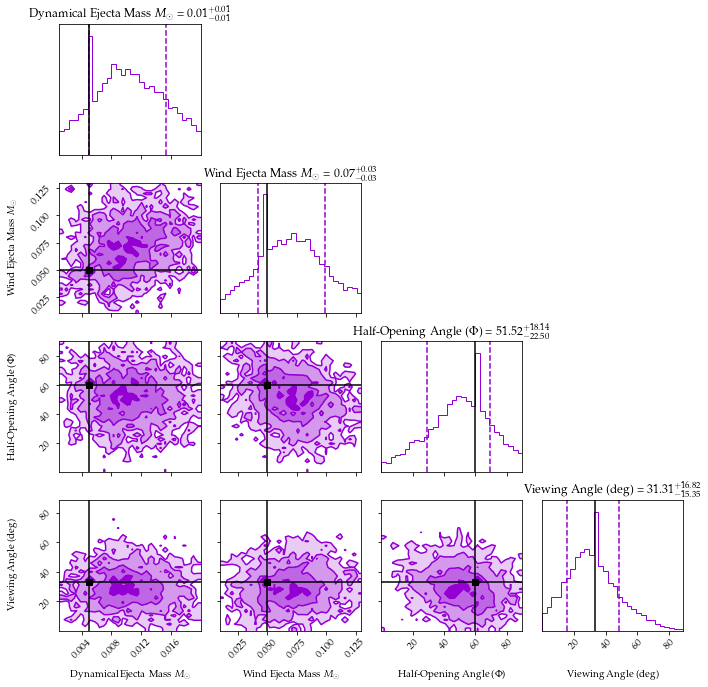

Walkers: 50
Iterations: 500
Emulator Calls: 22710
Total Runtime: 18.0mins


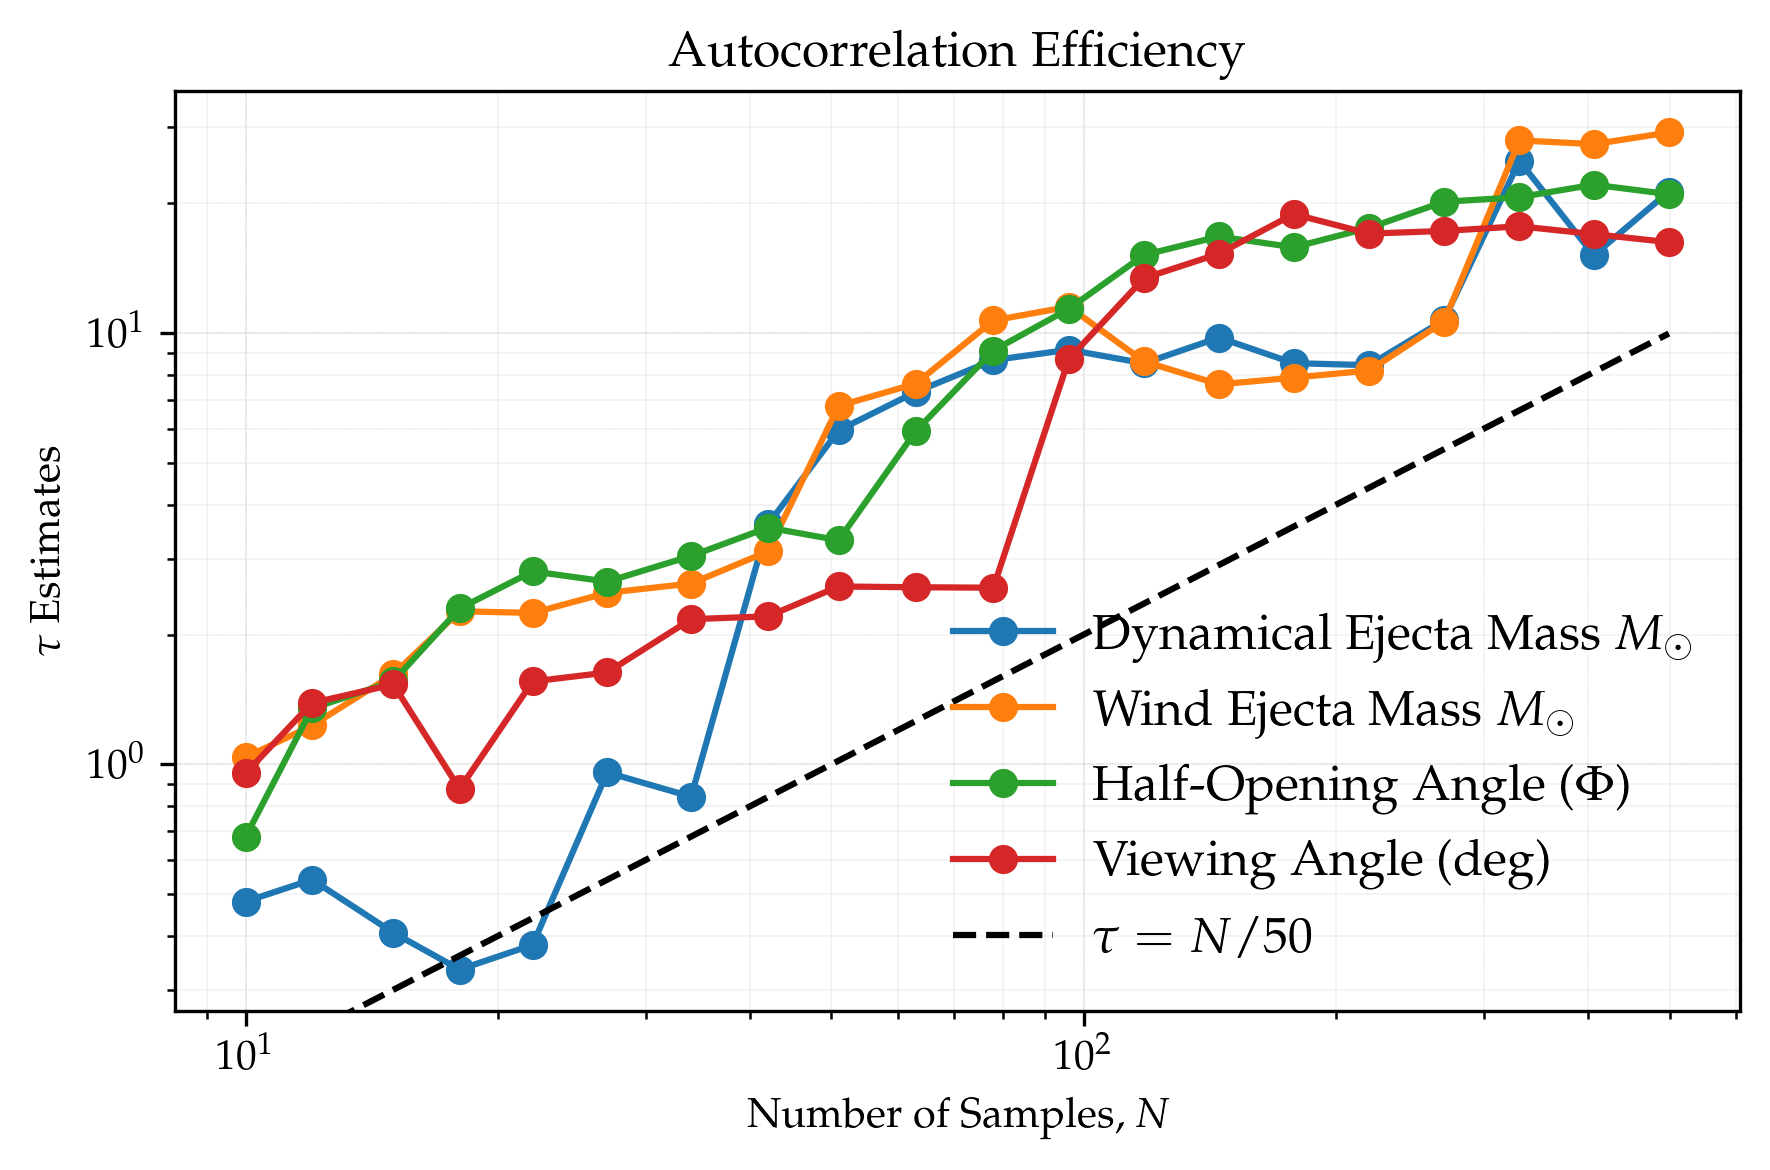

In [5]:
inference.main(yerr_percentage = 1e-12)
inference.samples = inference.sampler.get_chain()
inference.plot_corner()
inference.plot_auto_correlation()
plt.show()

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


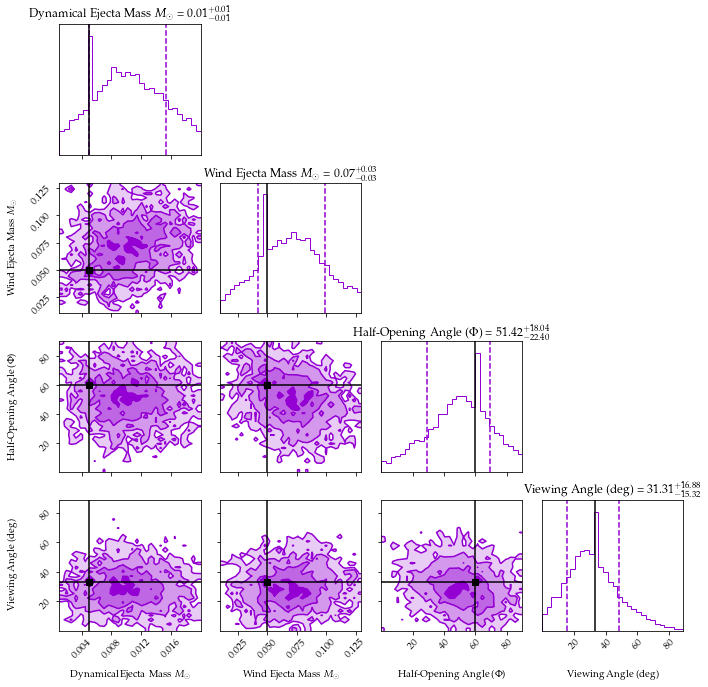

Walkers: 50
Iterations: 510
Emulator Calls: 355
Total Runtime: 18.36mins


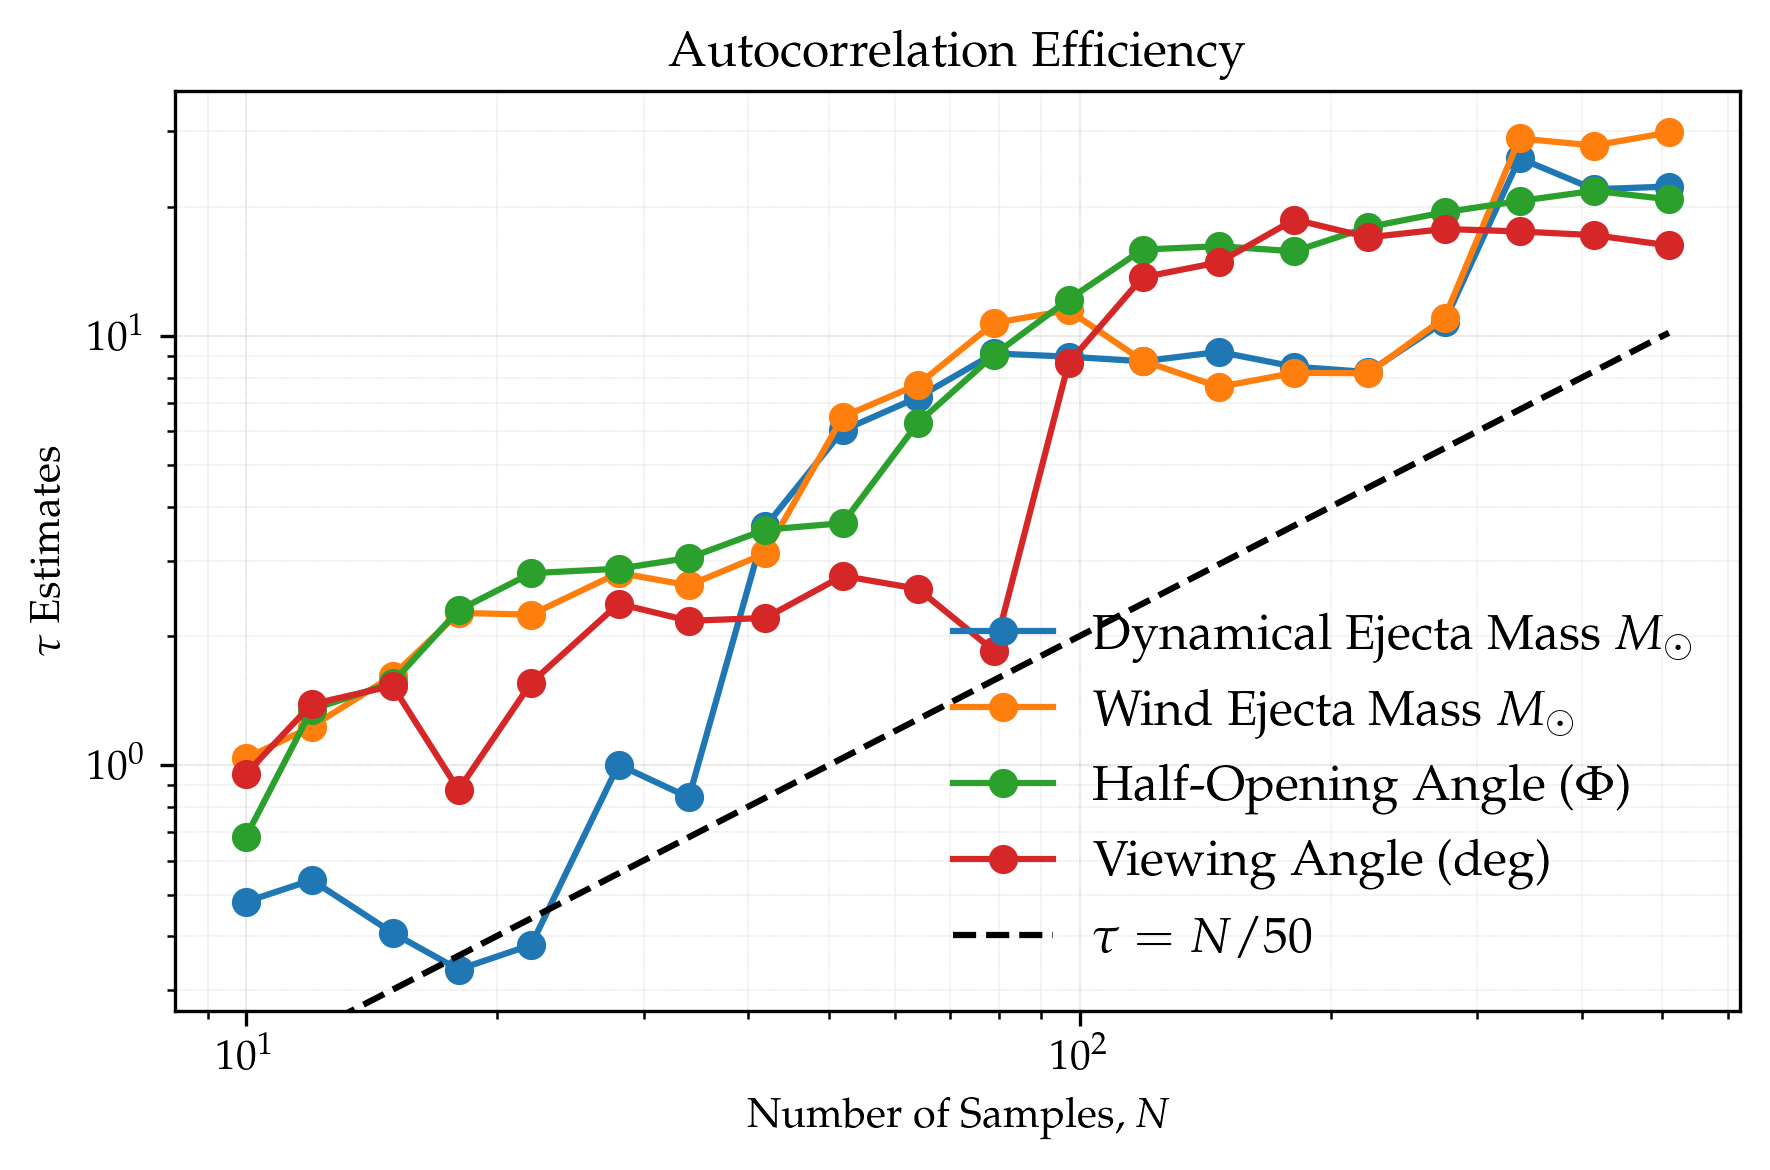

In [6]:
inference.niter = 10
inference.retrain()
inference.samples = inference.sampler.get_chain(discard = 10)
inference.plot_corner()
inference.plot_auto_correlation()
# inference.plot_chains()
plt.show()

100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


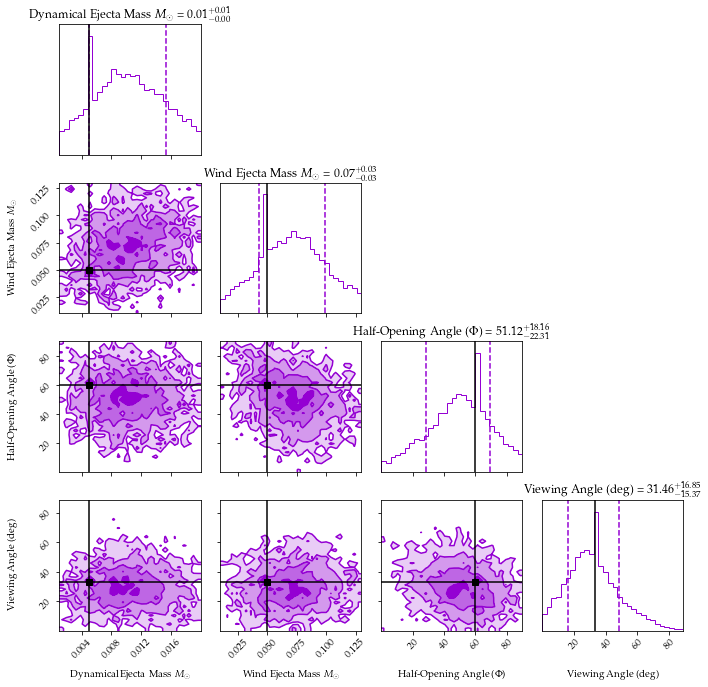

Walkers: 50
Iterations: 530
Emulator Calls: 771
Total Runtime: 19.07mins


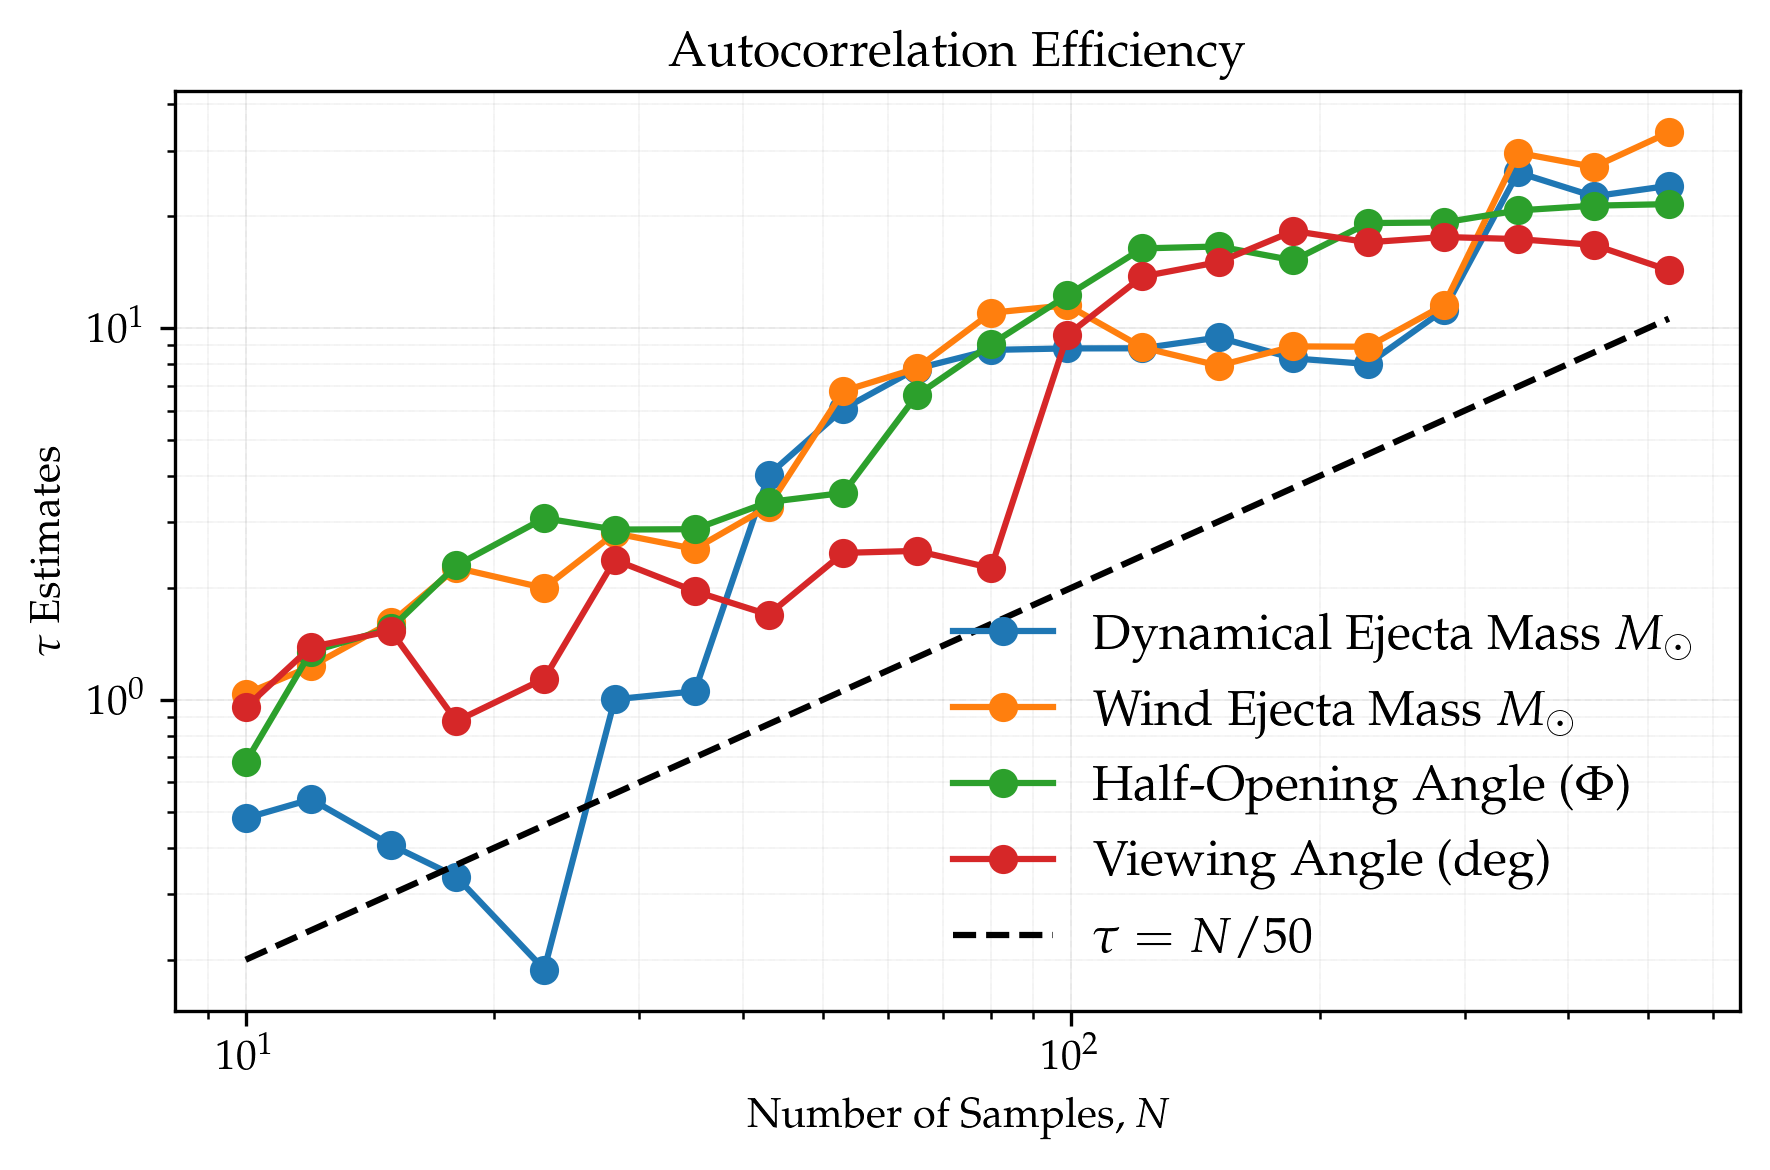

In [7]:
inference.niter = 20
inference.retrain()
inference.samples = inference.sampler.get_chain(discard = 10)
inference.plot_corner()
inference.plot_auto_correlation()
# inference.plot_chains()
plt.show()

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


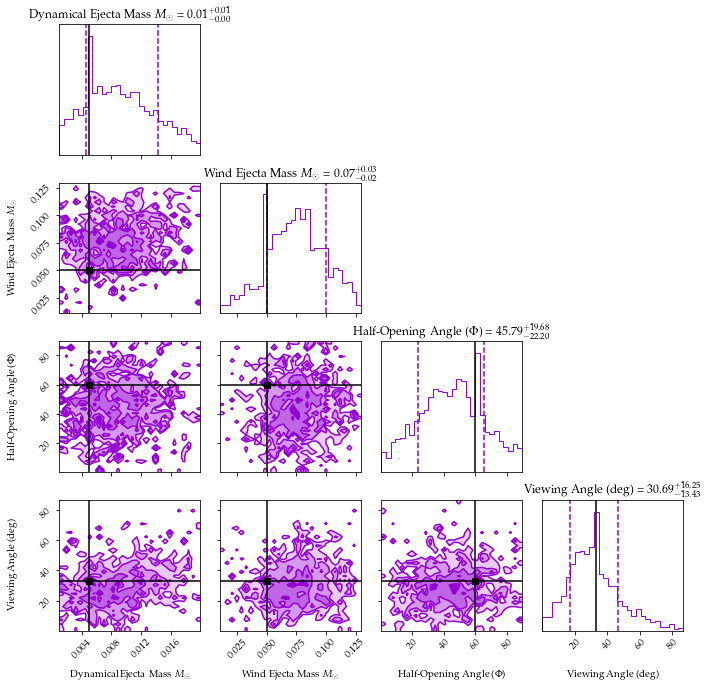

Walkers: 50
Iterations: 590
Emulator Calls: 746
Total Runtime: 21.76mins


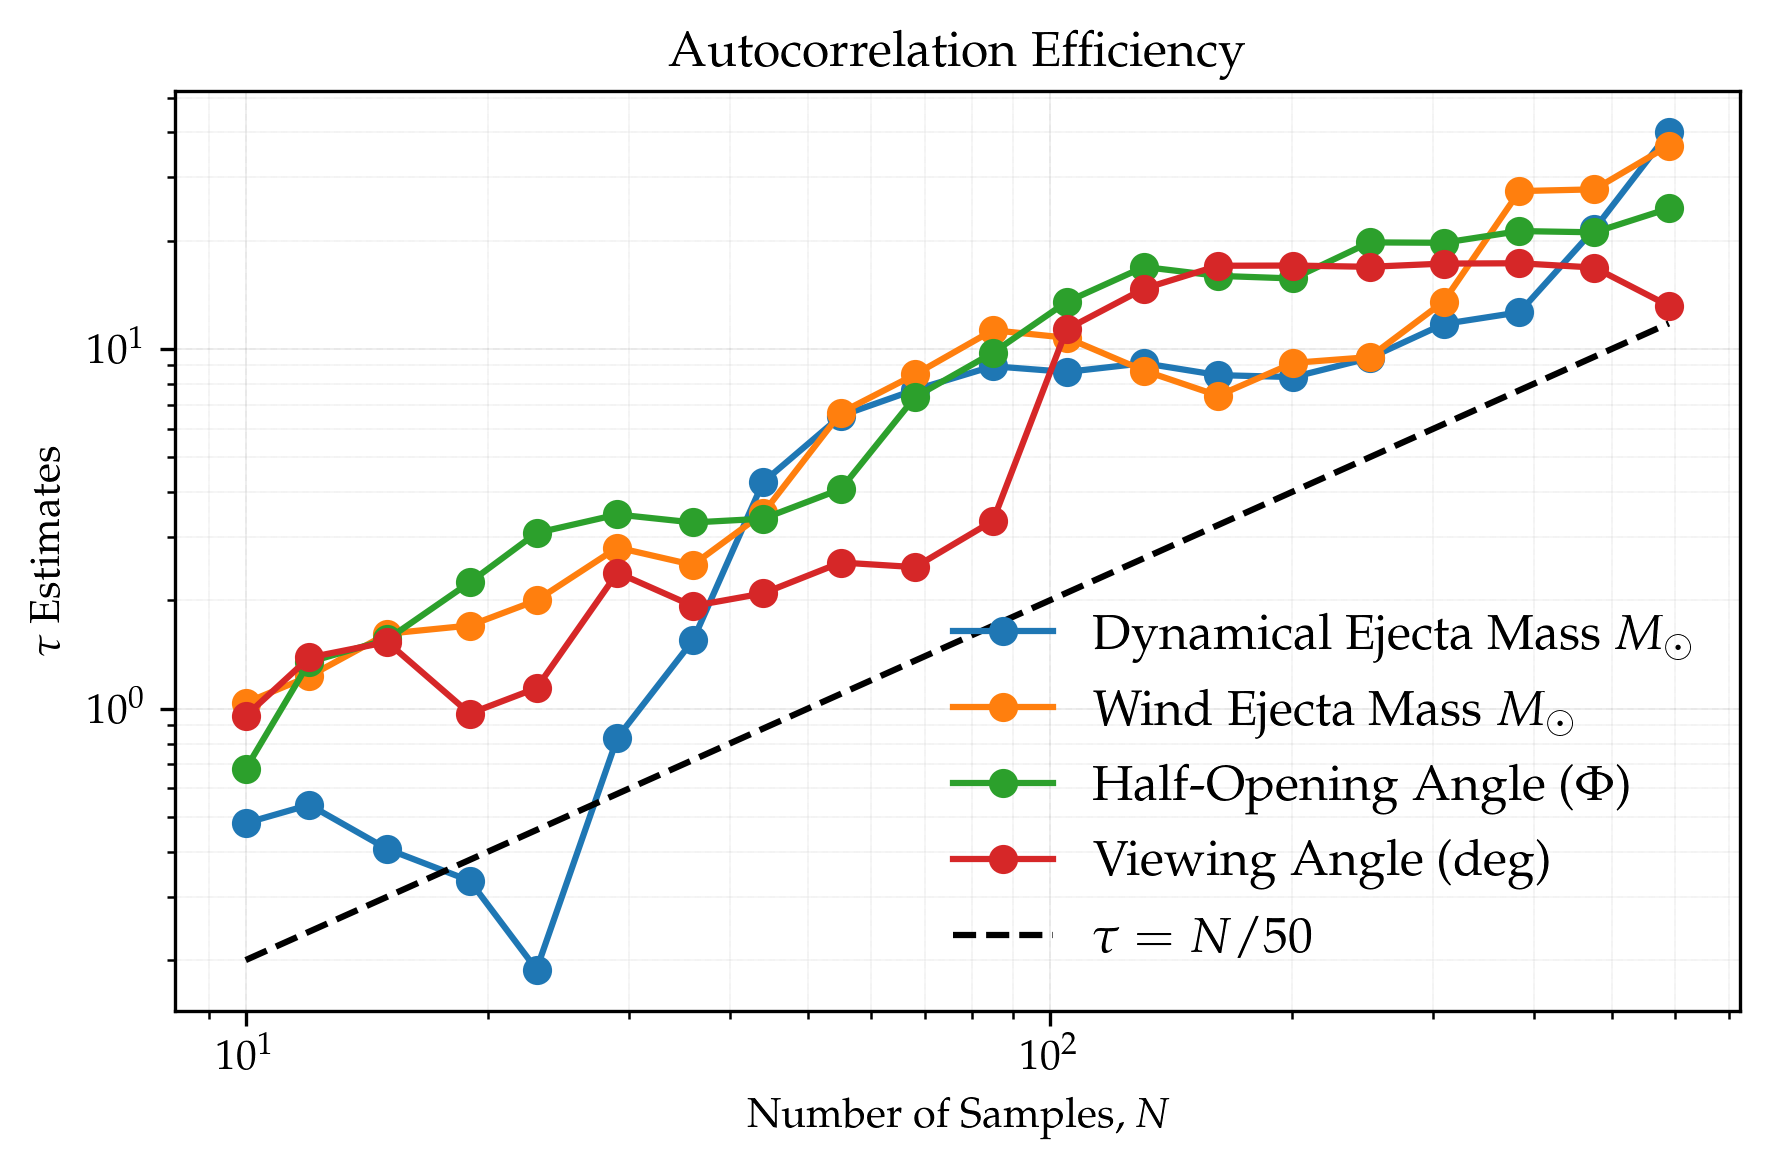

In [10]:
inference.niter = 20
inference.retrain()
inference.samples = inference.sampler.get_chain(discard = 500)
inference.plot_corner()
inference.plot_auto_correlation()
# inference.plot_chains()
plt.show()

100%|██████████| 1000/1000 [30:06<00:00,  1.81s/it]


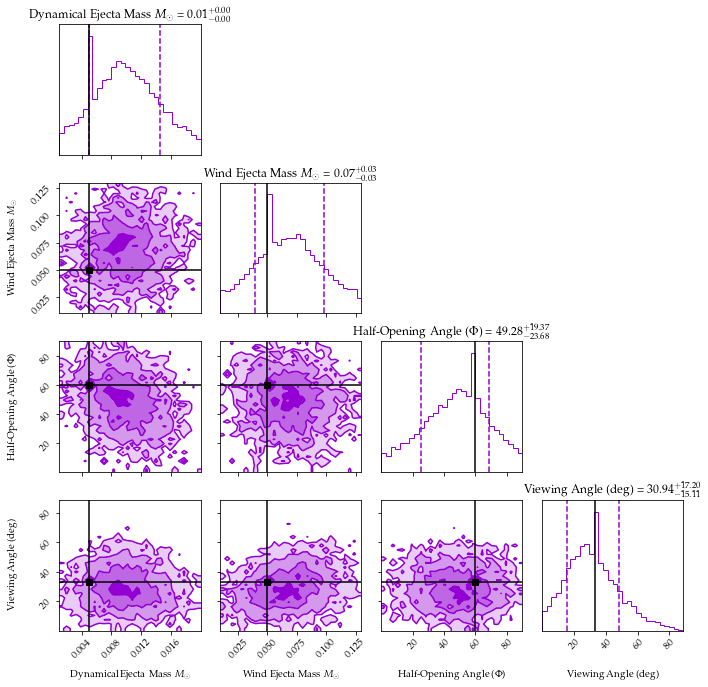

Walkers: 50
Iterations: 1590
Emulator Calls: 36962
Total Runtime: 52.15mins


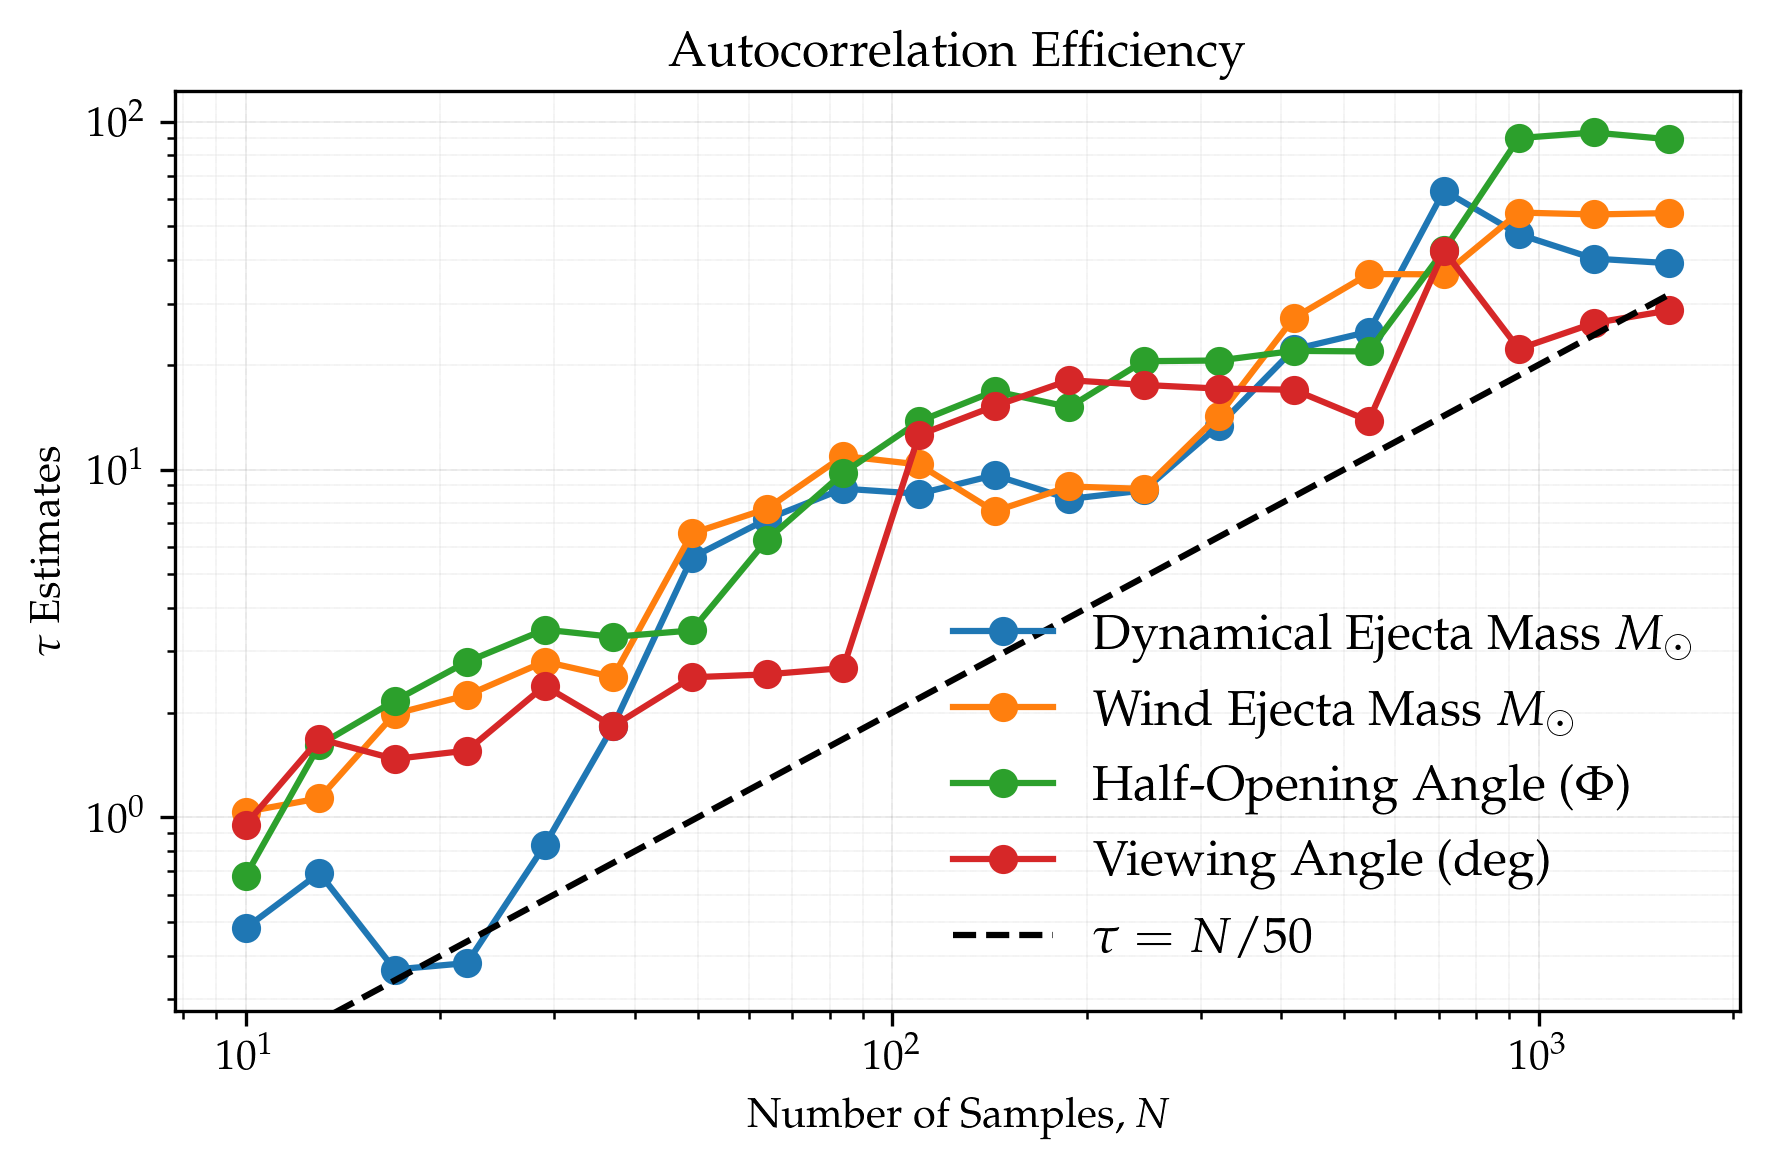

In [11]:
inference.niter = 1000
inference.retrain()
inference.samples = inference.sampler.get_chain(discard = 1000)
inference.plot_corner()
inference.plot_auto_correlation()
# inference.plot_chains()
plt.show()

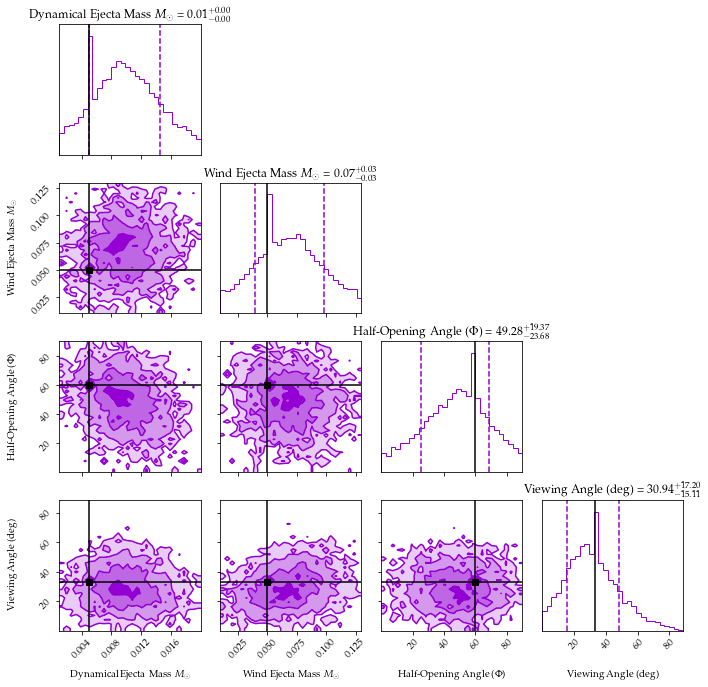

Walkers: 50
Iterations: 1590
Emulator Calls: 36962
Total Runtime: 52.18mins


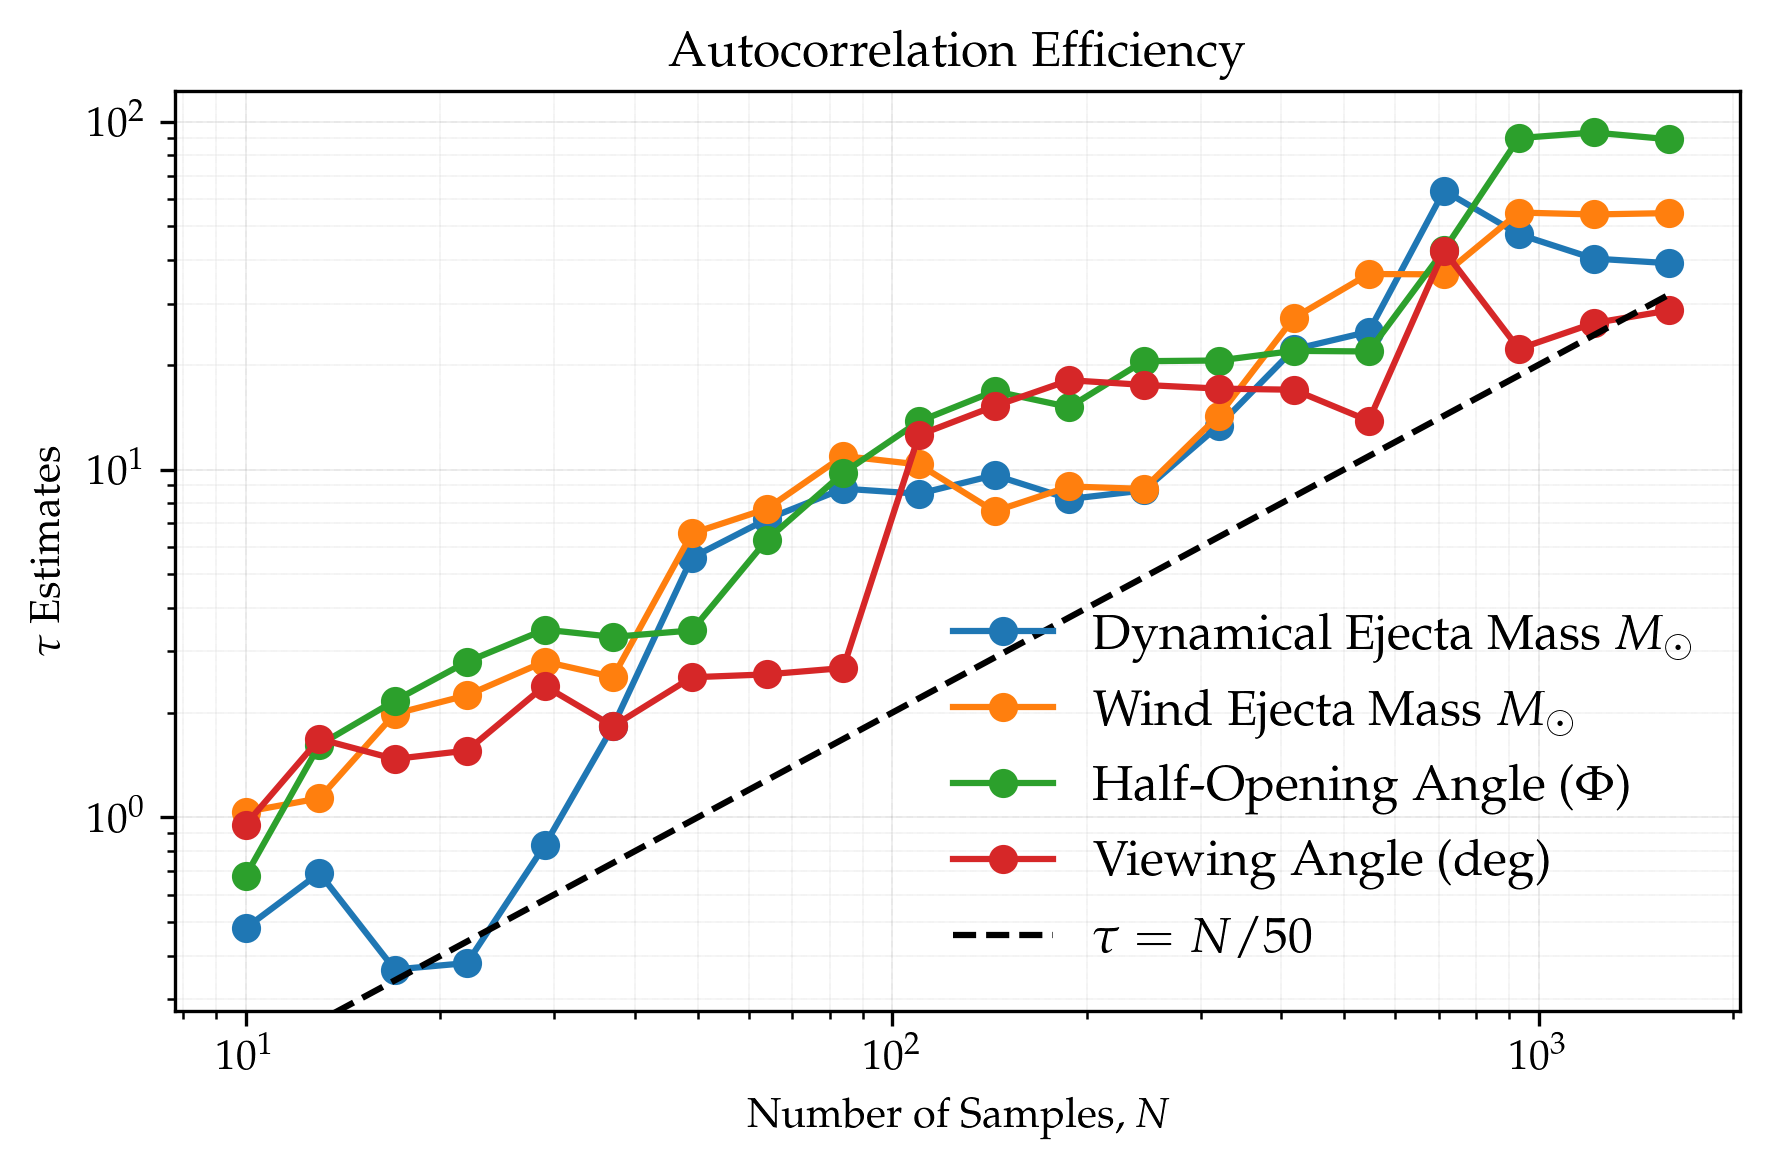

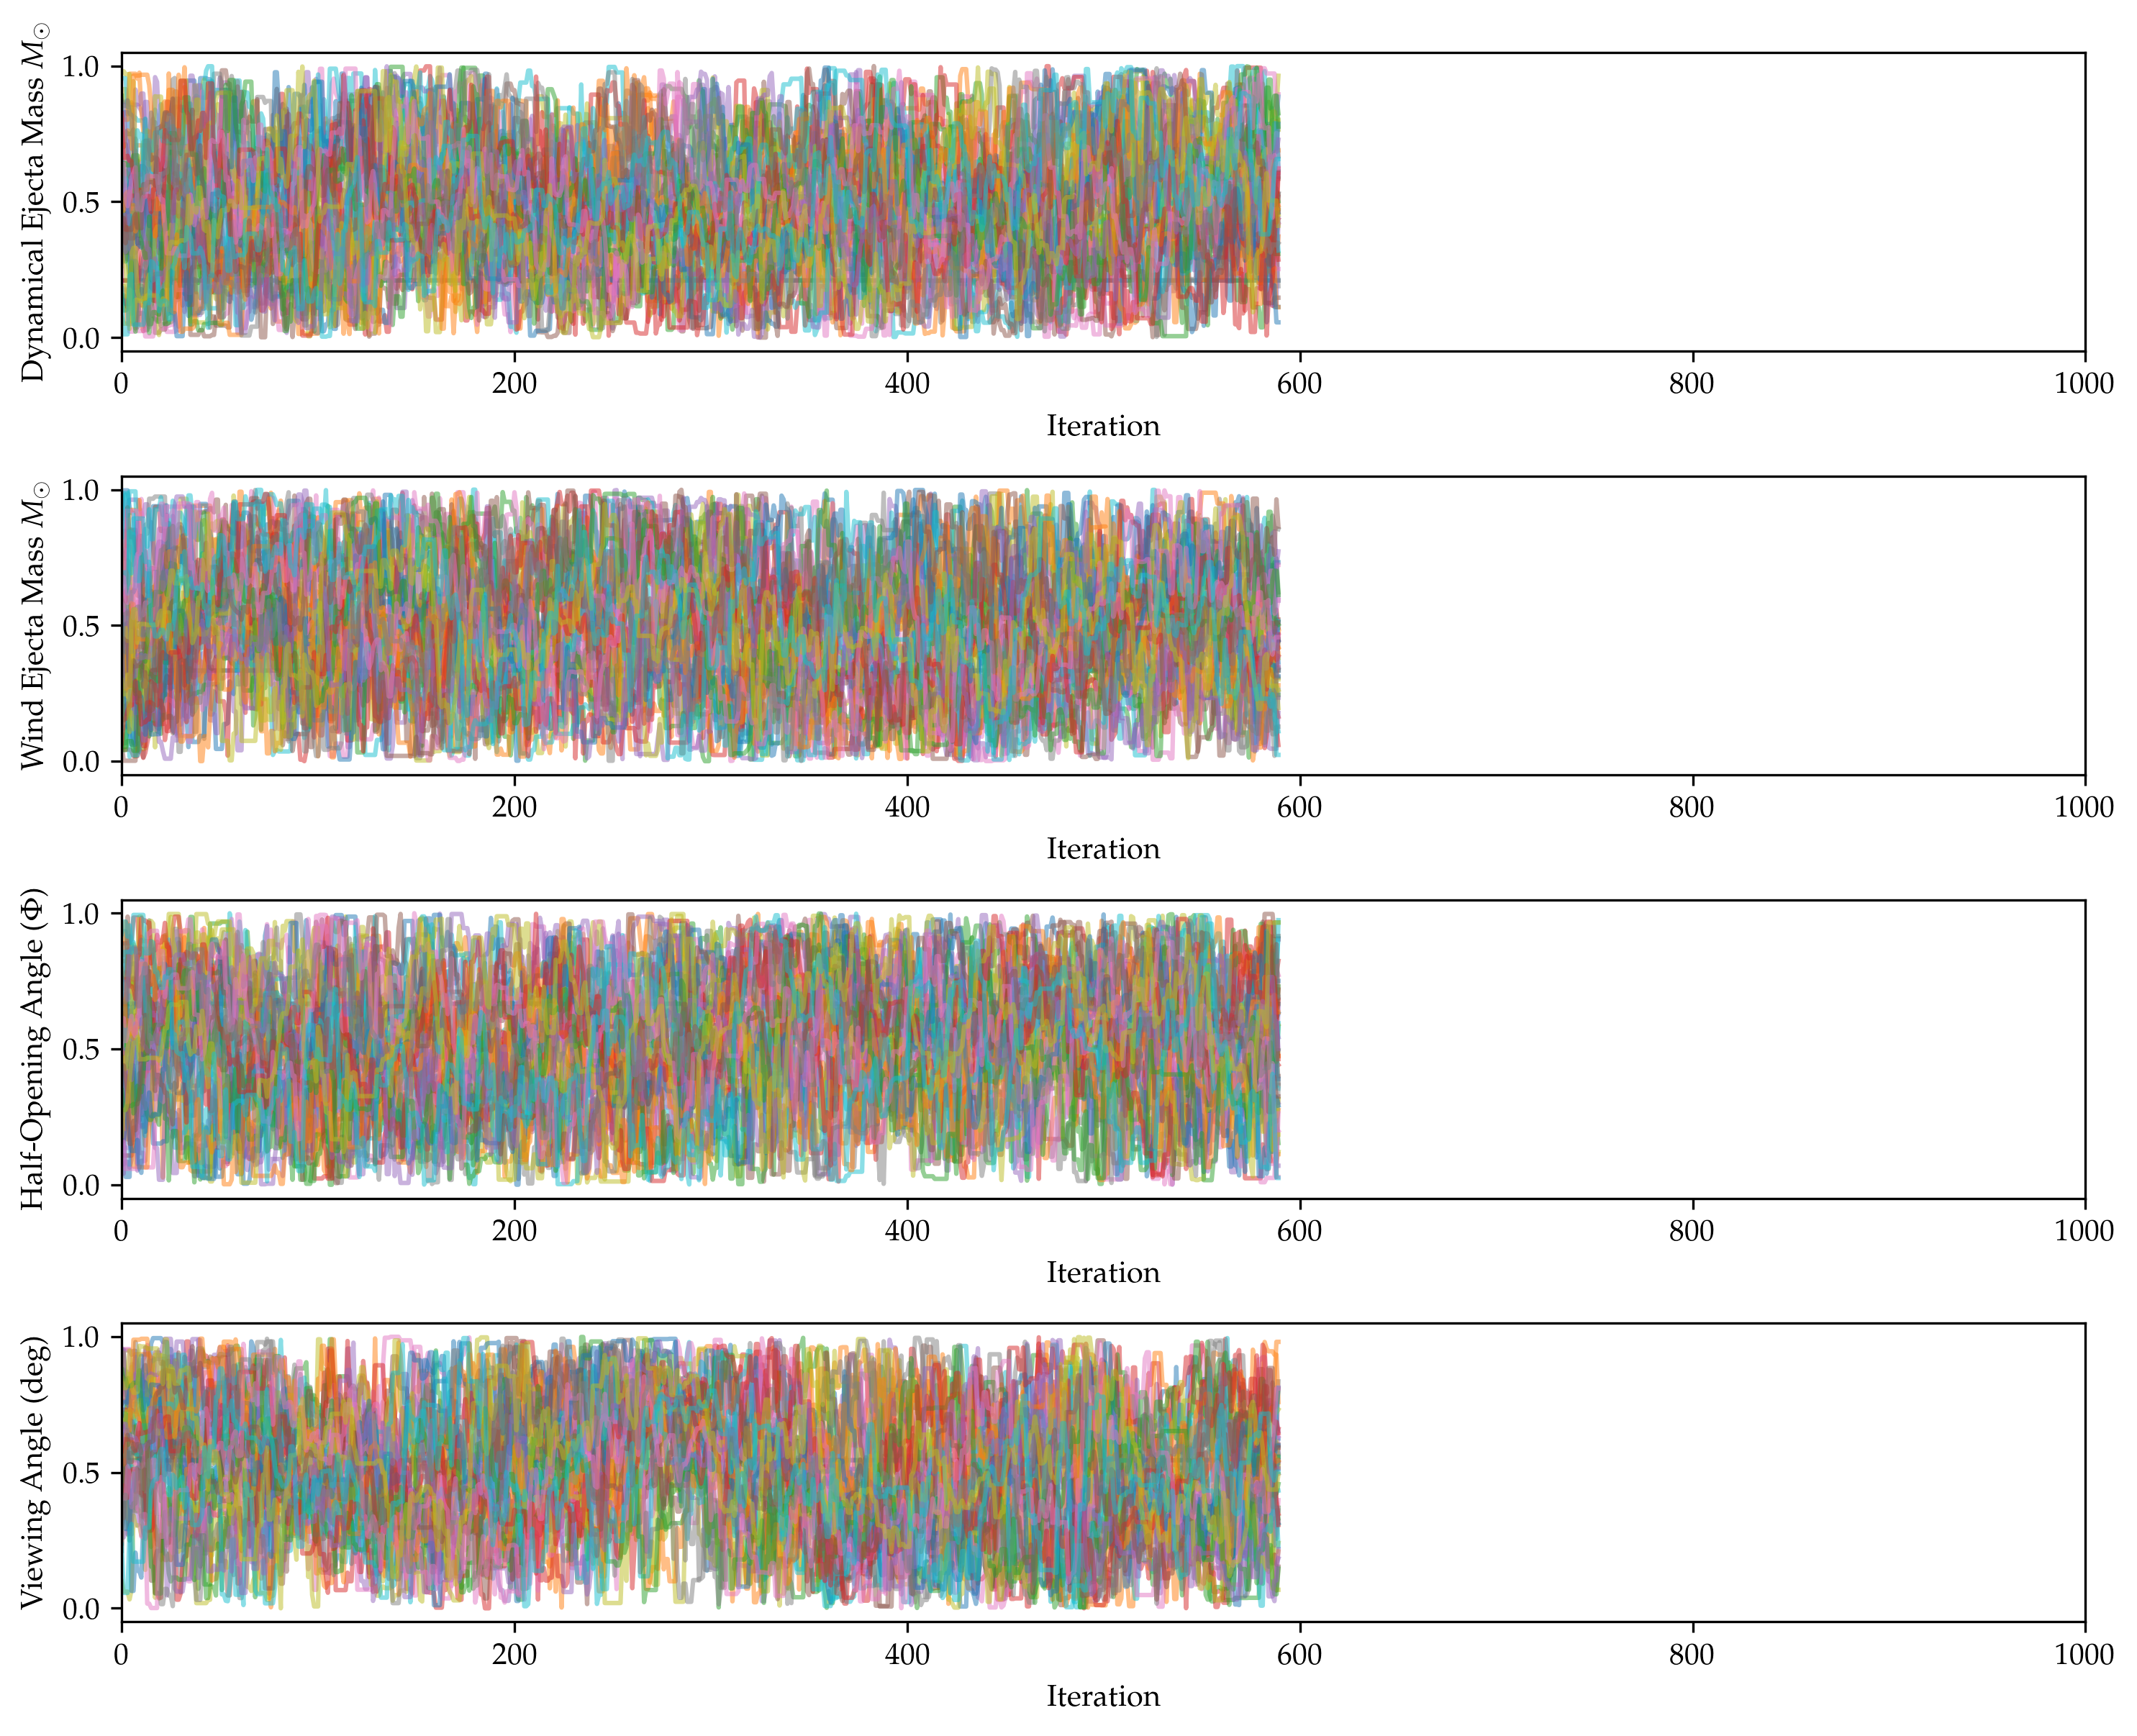

In [12]:
inference.samples = inference.sampler.get_chain(discard = 1000)
inference.plot_corner()
inference.plot_auto_correlation()
inference.plot_chains()
plt.show()

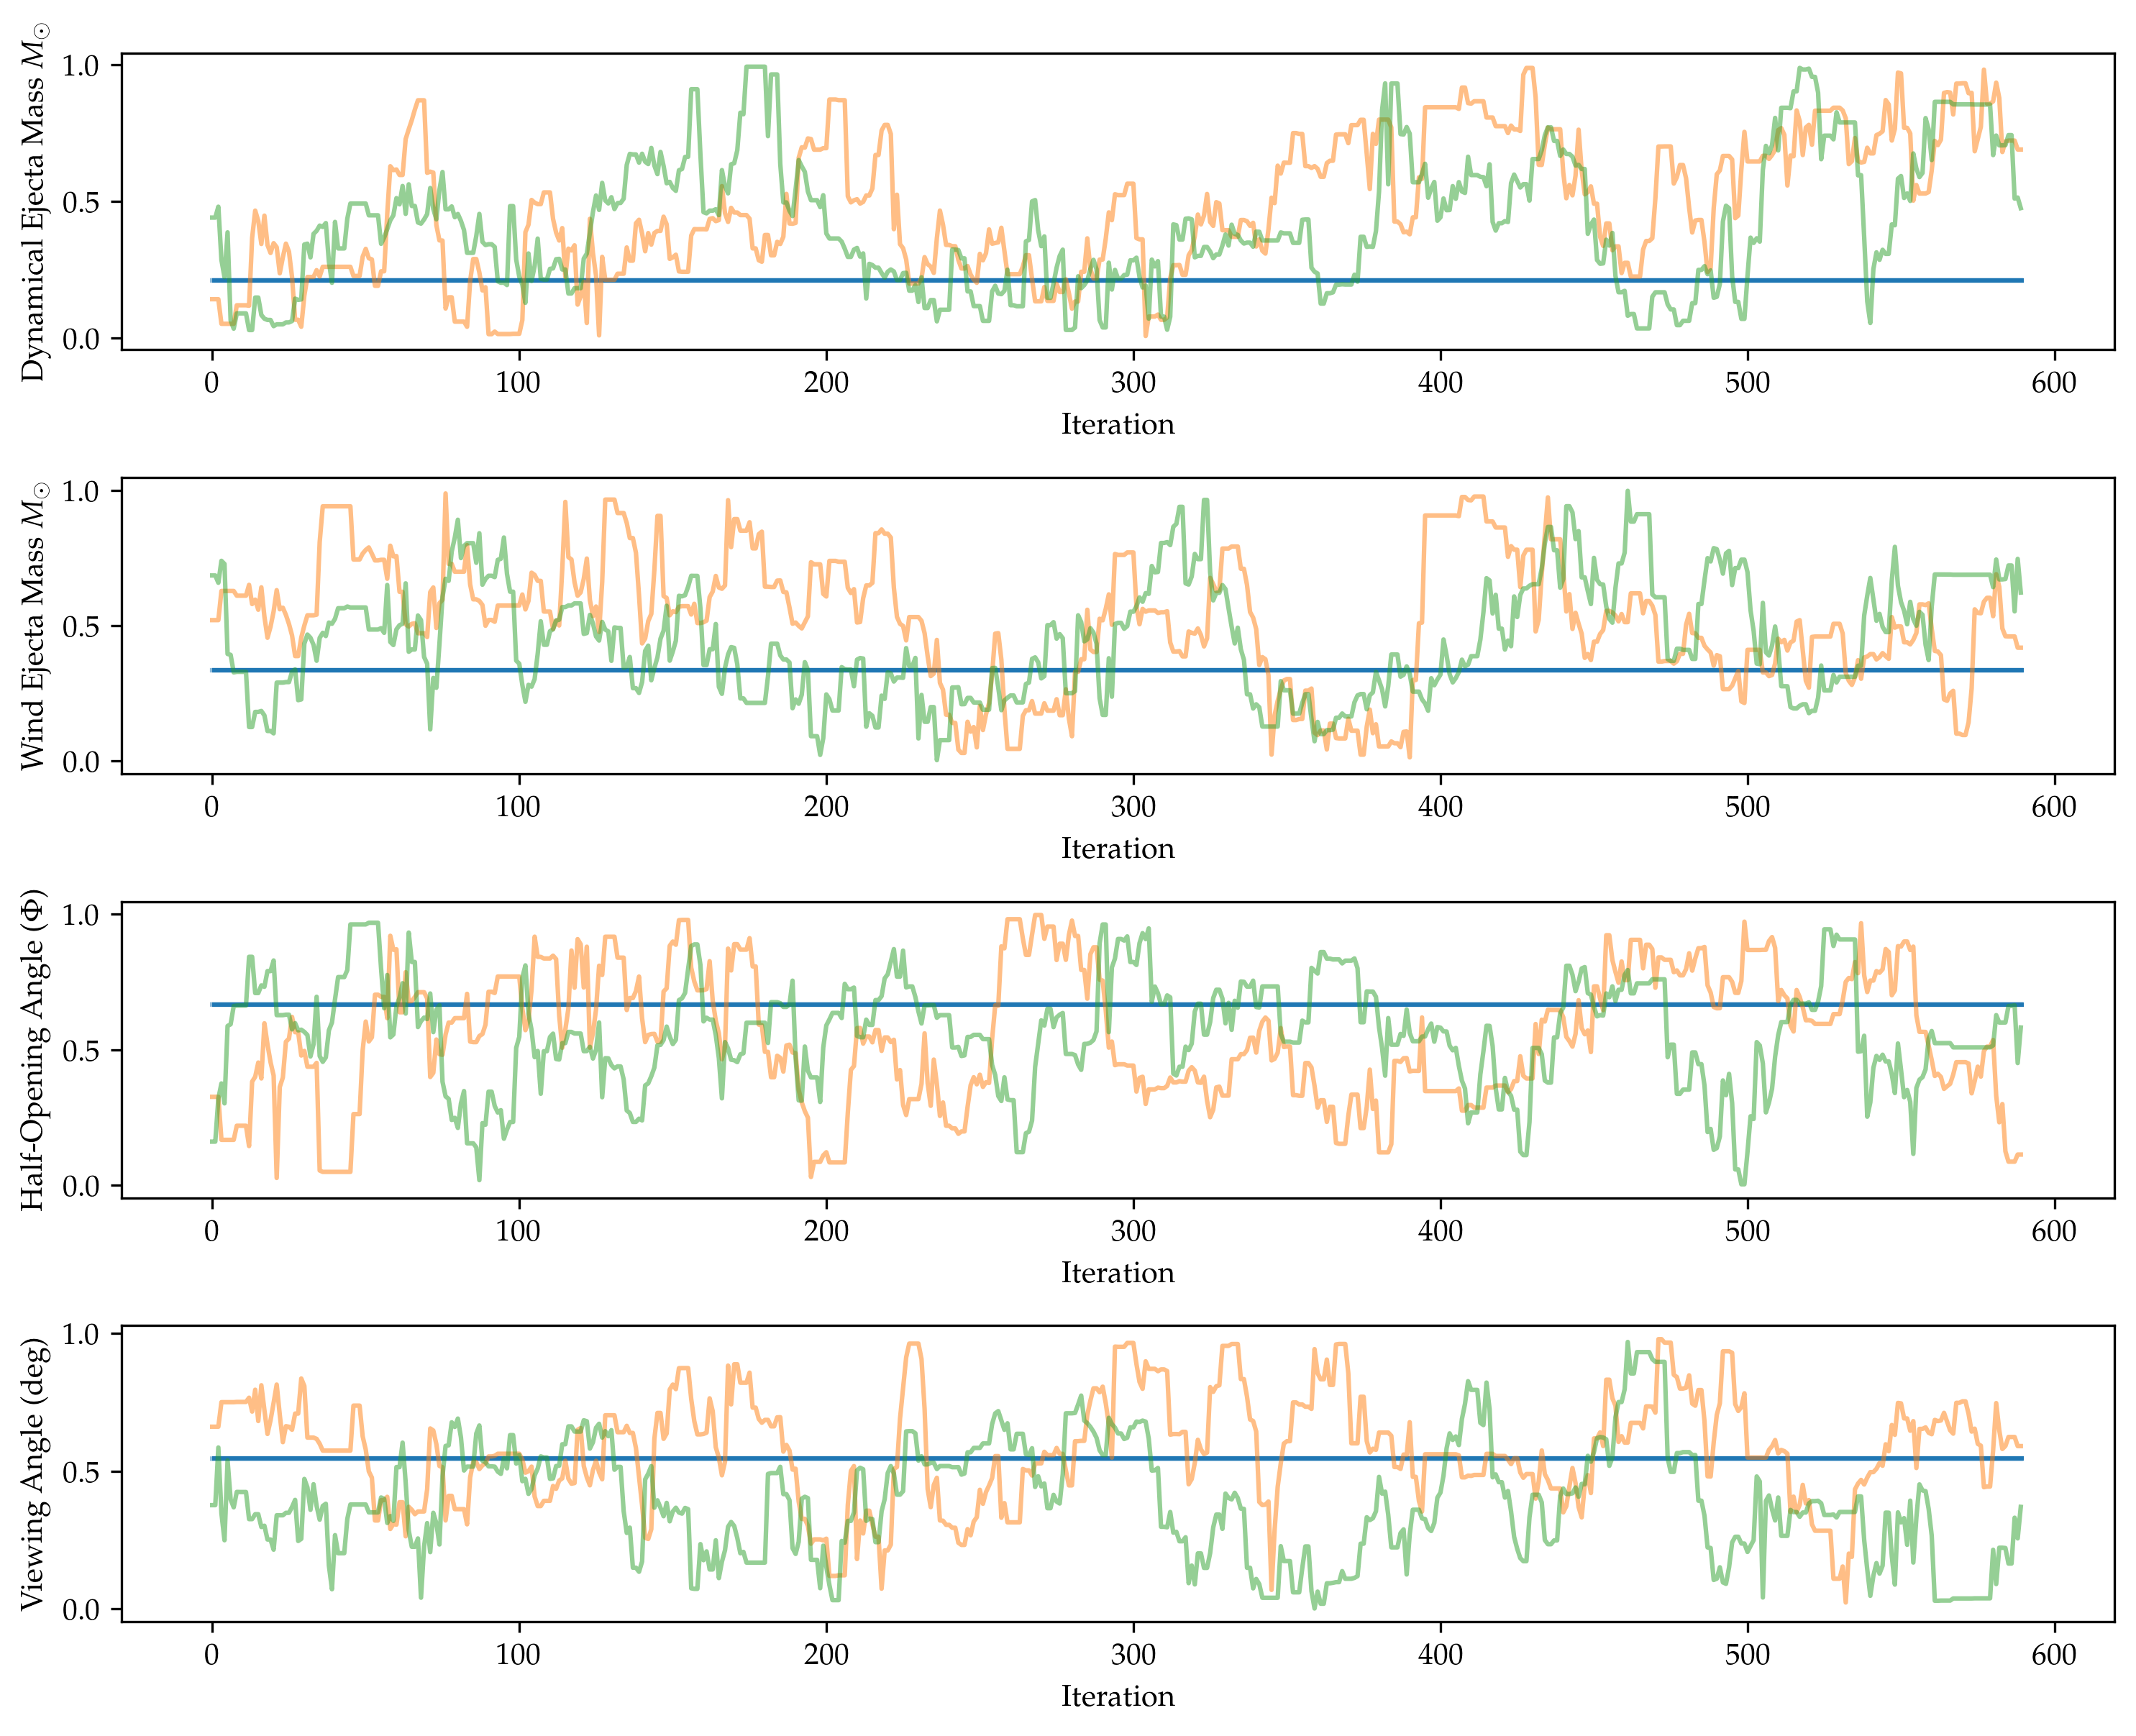

In [13]:
turth_normed = inference.normalization_helper(inference.truth_arr)

self = inference
samples = self.samples
# plot_walkers = self.nwalkers
plot_walkers = 3
plt.figure(dpi=300, figsize=(10, 8))
plt.subplot(4, 1, 1)
[plt.plot(samples[:, i, 0], alpha=0.5) for i in range(plot_walkers)]
plt.hlines(turth_normed[0], xmin = 0, xmax = len(samples[:, 0, 0]))
plt.xlabel('Iteration')
plt.ylabel(self.labs[0])

plt.subplot(4, 1, 2)
[plt.plot(samples[:, i, 1], alpha=0.5) for i in range(plot_walkers)]
plt.xlabel('Iteration')
plt.hlines(turth_normed[1], xmin = 0, xmax = len(samples[:, 0, 0]))
plt.ylabel(self.labs[1])

plt.subplot(4, 1, 3)
[plt.plot(samples[:, i, 2], alpha=0.5) for i in range(plot_walkers)]
plt.xlabel('Iteration')
plt.ylabel(self.labs[2])
plt.hlines(turth_normed[2], xmin = 0, xmax = len(samples[:, 0, 0]))
plt.tight_layout()

plt.subplot(4, 1, 4)
[plt.plot(samples[:, i, 3], alpha=0.5) for i in range(plot_walkers)]
plt.xlabel('Iteration')
plt.ylabel(self.labs[3])
plt.hlines(turth_normed[3], xmin = 0, xmax = len(samples[:, 0, 0]))
plt.tight_layout()

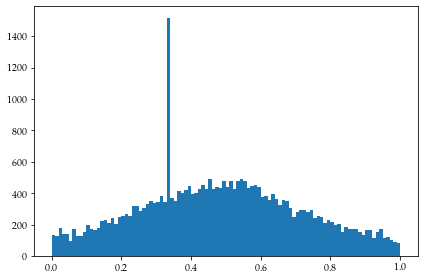

In [14]:
plt.hist(samples[:, :, 1].flatten(), bins = 100)
plt.show()

In [ ]:
# for i in tqdm(range(self.nwalkers)):
#     plt.figure()
#     [plt.plot(samples[:, i, 3], alpha=0.5)]
#     plt.xlabel('Iteration')
#     plt.ylabel(self.labs[3])
#     plt.hlines(turth_normed[3], xmin = 0, xmax = len(samples[:, 0, 0]))
#     plt.tight_layout()

In [15]:
theta_MAP = []
theta_2_sig = []
for i in range(4):
    flat_samples = samples[:, :, i]
    max_a_post = np.percentile(flat_samples[:, :], [2.5, 50, 97.5])[1]
    two_sig = np.percentile(flat_samples[:, :], [2.5, 50, 97.5])[2]
    theta_MAP.append(max_a_post)
    theta_2_sig.append(two_sig)

In [16]:
x1, MAP = inference.predict_fluxes(theta_MAP[0], theta_MAP[1], theta_MAP[2], theta_MAP[3])
x2, two_sig = inference.predict_fluxes(theta_2_sig[0], theta_2_sig[1], theta_2_sig[2], theta_2_sig[3])
x3, outside = inference.predict_fluxes(1, 1, 1, 1)
theta_outside = np.array([1, 1, 1, 1], dtype = float)

In [17]:
mejdyn, mejwind, phi, iobs = inference.truth_arr

y = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{int(phi)}_iobs{int(iobs)}.npy")
filters = ["sdss::u", "sdss::g", "sdss::r", "sdss::i", "sdss::z",
           "swope2::y", "swope2::J", "swope2::H"]

m_complete = []
gp.split = 1
gp._split = 1
gp.wv_range = np.arange(100, 3600, 10)
t = gp._t_helper()
for i in range(len(filters)):
    source = sncosmo.TimeSeriesSource(t, gp.wv_range * 10, 10 ** y)
    m = source.bandmag(filters[i], "ab", t)
    m_complete.append(m)
truth = np.array(m_complete, dtype=float).T

In [21]:
vals = [theta_MAP, theta_2_sig, theta_outside, inference.normalization_helper(inference.truth_arr)]
vals_logl = []
for item in vals:
    print(item)
    y = truth
    y_model = inference.predict_fluxes(item[0], item[1], item[2], item[3])
    yerr = 1e-12*y
    logl = - 0.5 * np.sum(((y - y_model) / yerr) ** 2)
    vals_logl.append(logl)
vals_logl
# list(inference.undo_normalization_helper(np.array(vals[-1])))

[0.4554341064119407, 0.47650722647511035, 0.547533773434131, 0.5140856899006983]
[0.9225808777974269, 0.9369412298487214, 0.9421976891850561, 0.934146644631955]
[1. 1. 1. 1.]
[0.21052632 0.33333333 0.66666667 0.54545455]


[-1.1804354647698005e+29,
 -1.1804354647698005e+29,
 -9.953863351710644e+28,
 -9.88289395416043e+28]

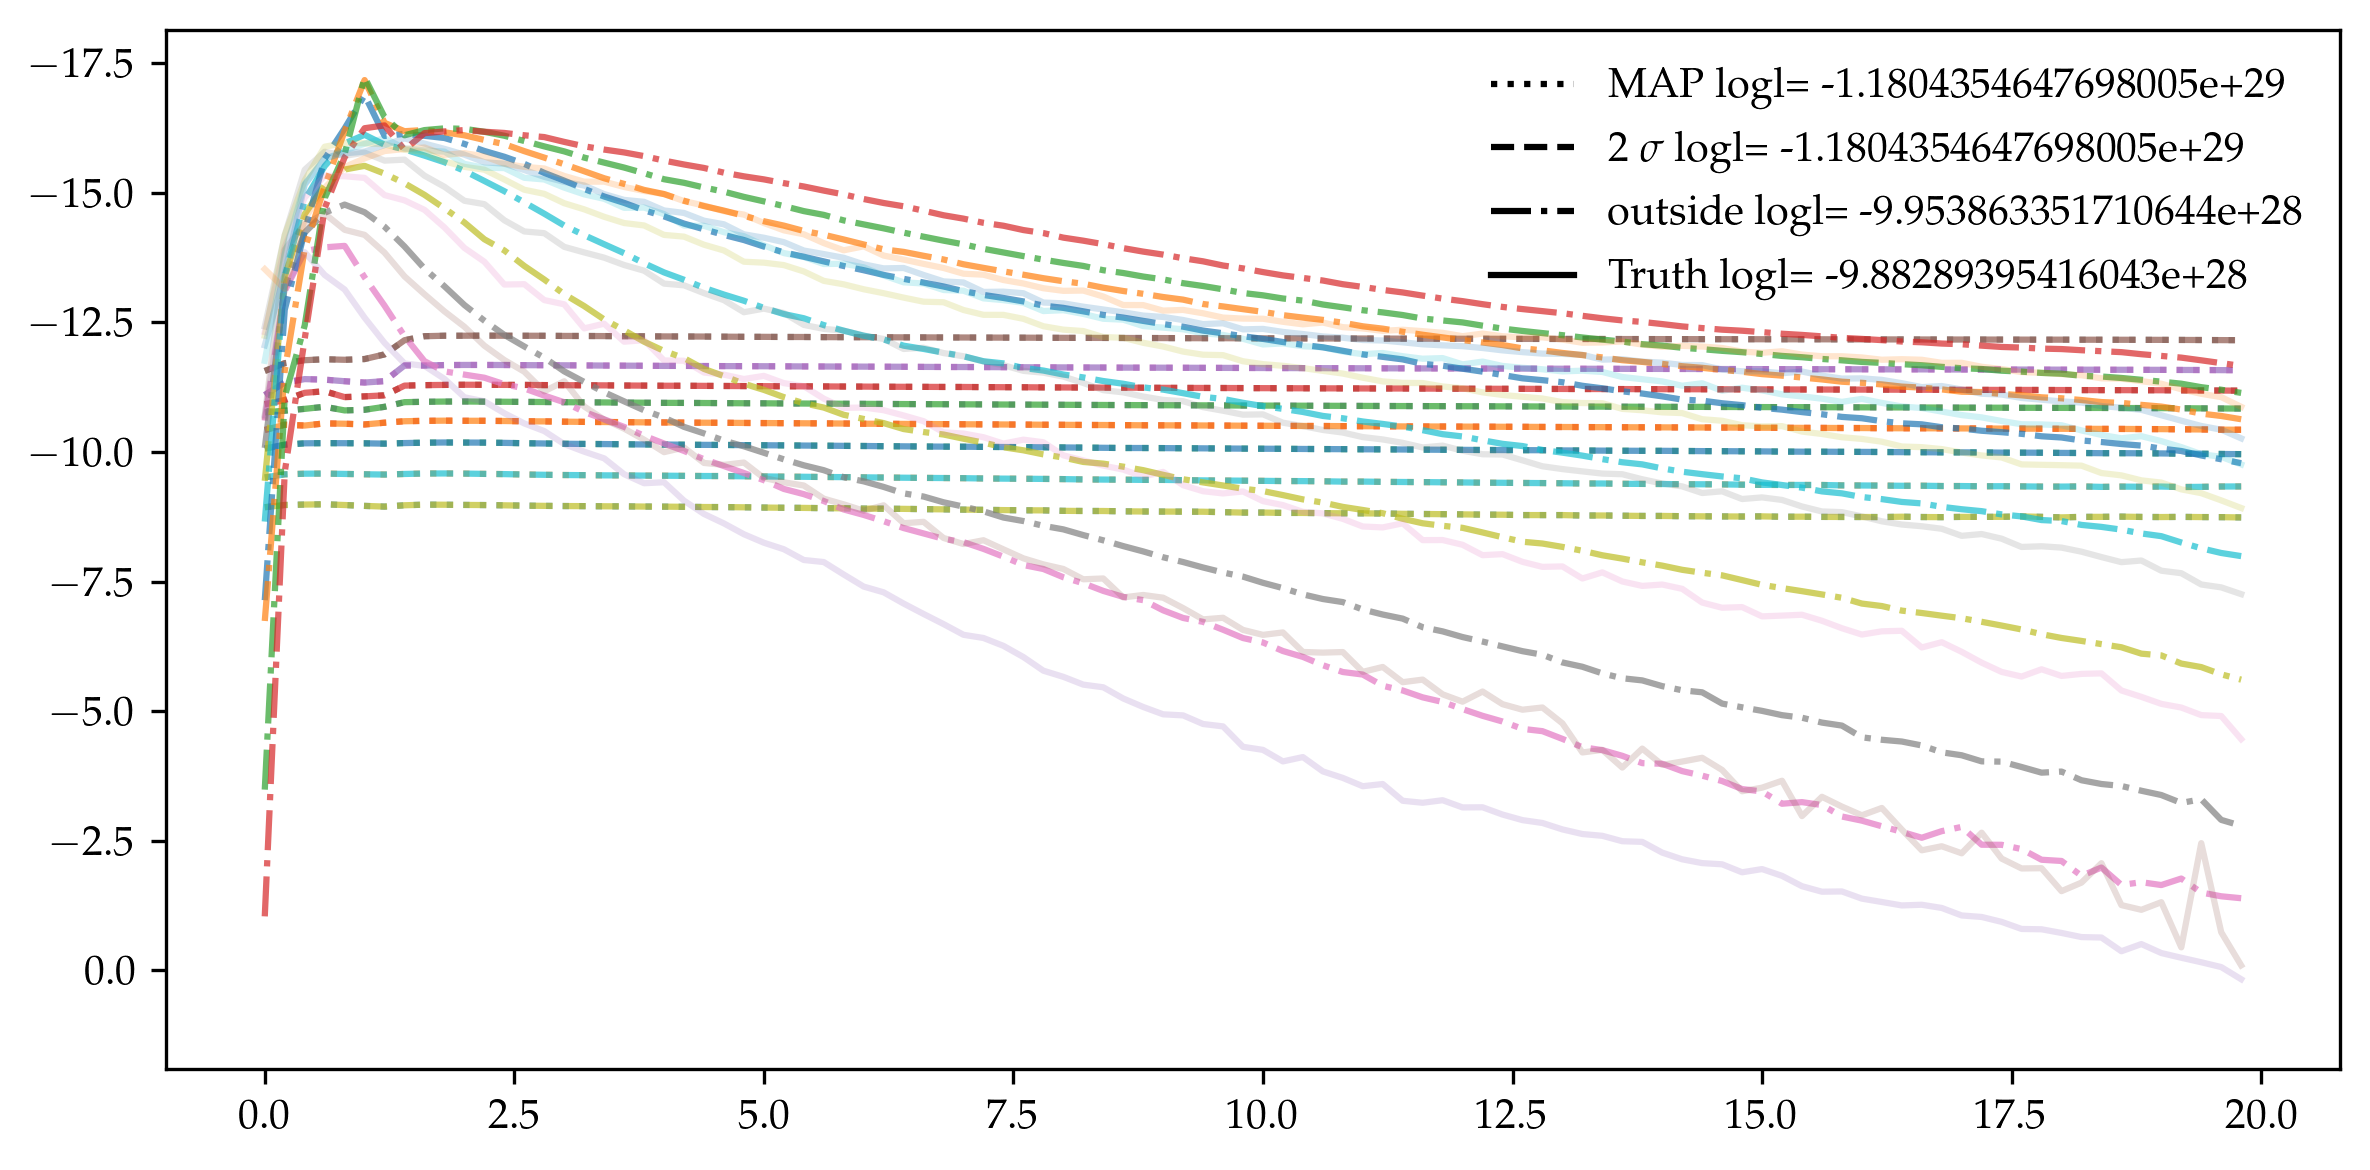

In [22]:
x = x1
plt.figure(dpi = 300, figsize = (8,4))
plt.plot(x1, MAP, alpha = 0.7, linestyle = "dotted")
plt.plot(x2, two_sig, alpha = 0.7, linestyle = "dashed")
plt.plot(x3, outside, alpha = 0.7, linestyle = "dashdot")
plt.plot(x1, truth, alpha = 0.2, linestyle = "solid")
    
plt.gca().invert_yaxis()
plt.plot(x[0], np.ones(x[0].shape), linestyle = "dotted", color = "black", label = f"MAP "f"logl= {vals_logl[0]}", alpha = 1)
plt.plot(x[0], np.ones(x[0].shape), linestyle = "dashed", color = "black", label = r"2 $\sigma$ "f"logl= {vals_logl[1]}", alpha = 1)
plt.plot(x[0], np.ones(x[0].shape), linestyle = "dashdot", color = "black", label = r"outside "f"logl= {vals_logl[2]}", alpha = 1)
plt.plot(x[0], np.ones(x[0].shape), linestyle = "solid", color = "black", label = r"Truth "f"logl= {vals_logl[3]}", alpha = 1)
plt.legend()
plt.show()